<a href="https://colab.research.google.com/github/algroznykh/visualML/blob/master/CPPN_style_transfer_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Style Transfer


![header image](https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-header.jpg =512x) 

This notebook uses [**Lucid**](https://github.com/tensorflow/lucid) to perform style transfer between two images, and show how different parameterizations affect that process.

This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is [as a colab notebook](https://colab.research.google.com/drive/1XuxLjIZj9MV-lRCpXHBhLo5A41Zs0f8E), which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**


## Install, Import, Load Model

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install -q lucid==0.2.3

     |████████████████████████████████| 40kB 2.7MB/s 


In [ ]:
# Imports

import numpy as np
import tensorflow as tf

from lucid.modelzoo import vision_models
from lucid.misc.io import show, load, save
from lucid.misc.tfutil import create_session

import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render

We will be writing a custom objective for style transfer, so let's grab this handy decorator that allows us to take a simple function and mark it as an objective in lucid:

In [ ]:
from lucid.optvis.objectives import wrap_objective

And we'll use our default vision model, GoogLeNet:

In [ ]:
model = vision_models.InceptionV1()
model.load_graphdef()

You can use this to see if you're running on a machine with a correctly configured GPU:

In [ ]:
tf.test.is_gpu_available()

True

## Load input images

First, let's take a look at the two images we want to transfer styles between. This code should feel familiar from the Lucid tutorial:

Later in the notebook there'll be an opportunity to upload your own images, too.

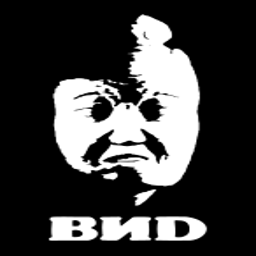

In [ ]:
import PIL
im = PIL.Image.fromarray(np.dstack([np.array(PIL.Image.open('/content/vid.png'))[...,0] for _ in range(3)])).resize((256,256))
# im = PIL.Image.fromarray(np.dstack([np.array(PIL.Image.open('/content/map-zfi.jpg'))[...,0] for _ in range(3)])).resize((256,256))

im

In [ ]:

# style_image = np.array(PIL.Image.open('/content/map-zfi.jpg').resize((256,256)), dtype=np.float32)[...,:3] / 256
# content_image = np.array(PIL.Image.open('/content/map-zfi.jpg').resize((256,256)), dtype=np.float32)[:,:,:3] / 256

style_image = np.array(im, dtype=np.float32)[...,:3] / 256
content_image = np.array(im, dtype=np.float32)[:,:,:3] / 256

## Introducing style transfer

In lucid, style transfer (rendering an image in the visual style of a different image) can be expressed compactly.

We feed two images, a **style image** and a **content image** into our model, which produces activations at all of its layers. 
From that we extract two subsets of activations, the style activations (orange) and the content activations (green), at different depths in the network. 

We then optimize an input to produce activations similar to the combined set of activations we extracted.

![styletransfer-diagram](https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-diagram.png =563x)

Which layers work best for that is an aesthetic choice. Recommended reading: [Feature Visualization](https://distill.pub/2017/feature-visualization), in which the hero graphic shows what kind of visual concepts get captured at which layers in the model we are using.

In [ ]:
style_layers = [
  'mixed3a',
  'mixed4b',
  'mixed4c',
  
]

content_layers = [
  'mixed3b'  # , 'mixed4a', 'mixed5a'
]

To feed two images + one that is being optimized into our network we will use the batch dimension of a cutsom parameterization. It consists simply of the paramaterization of the optimized image stacked with the two images.

(We also use cropping to allow style images of a larger size than content images.)

In [ ]:

from tensorflow.contrib import slim


def composite_activation(x):
  x = tf.atan(x)
  # Coefficients computed by:
  #   def rms(x):
  #     return np.sqrt((x*x).mean())
  #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
  #   print(rms(a), rms(a*a))
  return tf.concat([x/0.67, (x*x)/0.6], -1)


def composite_activation_unbiased(x):
  x = tf.atan(x)
  # Coefficients computed by:
  #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
  #   aa = a*a
  #   print(a.std(), aa.mean(), aa.std())
  return tf.concat([x/0.67, (x*x-0.45)/0.396], -1)

def composite_activation_sin(x):
  x = tf.sin(x)
  # Coefficients computed by:
  #   a = np.arcsin(np.random.normal(0.0, 1.0, 10**6))
  #   aa = a*a
  #   print(a.std(), aa.mean(), aa.std())
  return tf.concat([x/0.631, (x*x)/0.616], -1)
  #   return tf.concat([x/0.63, (x*x-0.4)/0.47], -1)


def relu_normalized(x):
  x = tf.nn.relu(x)
  # Coefficients computed by:
  #   a = np.random.normal(0.0, 1.0, 10**6)
  #   a = np.maximum(a, 0.0)
  #   print(a.mean(), a.std())
  return (x-0.40)/0.58


def image_cppn(
    size,
    num_output_channels=3,
    num_hidden_channels=24,
    num_layers=8,
    activation_fn=composite_activation,
    normalize=False):
  r = 3.0**0.5  # std(coord_range) == 1.0
  coord_range = tf.linspace(-r, r, size)
  y, x = tf.meshgrid(coord_range, coord_range, indexing='ij')
  net = tf.expand_dims(tf.stack([x, y], -1), 0)  # add batch dimension

  with slim.arg_scope([slim.conv2d], kernel_size=1, activation_fn=None):
    for i in range(num_layers):
      in_n = int(net.shape[-1])
      net = slim.conv2d(
          net, num_hidden_channels,
          # this is untruncated version of tf.variance_scaling_initializer
          weights_initializer=tf.random_normal_initializer(0.0, np.sqrt(1.0/in_n)),
      )
      if normalize:
        net = slim.instance_norm(net)
      net = activation_fn(net)

    rgb = slim.conv2d(net, num_output_channels, activation_fn=tf.nn.sigmoid,
                      weights_initializer=tf.zeros_initializer())
  return rgb


def gl_image_cppn(
    size,
    num_output_channels=3,
    num_hidden_channels=24,
    num_layers=8,
    batch_size=1,
    activation_fn=composite_activation,
    biases_initializer=None,
    weights_initializer=None,
    include_meshgrid=True,
    include_sininput=False,
    jitter_input=None,
    weights_regularizer=None,
    num_noise_channels=-1,
    
    normalize=False):
    '''
    Allowed 'activation_fn' to be a list as well to have different activations per layer.
    If `num_noise_channels > 0`, will not feed in meshgrid, but rather multiple channels of different
    scaled noise
    '''
    r = 3.0**0.5  # std(coord_range) == 1.0
    coord_range = tf.linspace(-r, r, size)
    net = None
    if num_noise_channels > 0:
        channel_size = size
        noise_channels = []
        for octave_i in range(num_noise_channels):
            noise_channel = tf.random_normal((batch_size, channel_size, channel_size, 1))
            dy, dx = tf.image.image_gradients(noise_channel)
            noise_channels.extend([tf.image.resize_bicubic(noise_channel, (size, size)),
                                   tf.image.resize_bicubic(dy, (size, size)),
                                   tf.image.resize_bicubic(dx, (size, size))
                                  ])
            channel_size = int(np.ceil(channel_size/2))
        net = tf.concat(noise_channels, -1)
    if include_meshgrid:
        y, x = tf.meshgrid(coord_range, coord_range, indexing='ij')
        meshstack = tf.tile(tf.expand_dims(tf.stack([x, y], -1), 0), (batch_size, 1, 1, 1))  # add batch dimension
        if jitter_input is not None:
            meshstack = meshstack + tf.random_uniform((batch_size, 1, 1, 2),
                                                      minval = jitter_input[0], maxval=jitter_input[1])
        if net is None:
            net = meshstack
        else:
            net = tf.concat([net, meshstack], -1)
    if include_sininput:
        y, x = tf.meshgrid(coord_range, coord_range, indexing='ij')
        meshstack = tf.tile(tf.expand_dims(tf.stack([x, y], -1), 0), (batch_size, 1, 1, 1))  # add batch dimension
        if net is None:
            net = meshstack
        else:
            net = tf.concat([net, meshstack], -1)
        
    with slim.arg_scope([slim.conv2d], kernel_size=1, activation_fn=None,
                        weights_regularizer=weights_regularizer):
        for i in range(num_layers):
            in_n = int(net.shape[-1])
            if isinstance(num_hidden_channels, list):
                hidden = num_hidden_channels[i]
            else:
                hidden = num_hidden_channels
                
            if isinstance(biases_initializer, list):
                layer_bias_initializer = biases_initializer[i]
            else:
                layer_bias_initializer = biases_initializer
            if layer_bias_initializer is None:
                layer_bias_initializer = tf.zeros_initializer()
                
            if isinstance(weights_initializer, list):
                layer_weight_initializer = weights_initializer[i]
            else:
                layer_weight_initializer = weights_initializer
            if layer_weight_initializer is None:
                layer_weight_initializer = tf.random_normal_initializer(0.0, np.sqrt(1.0/in_n))

            net = slim.conv2d(
                net, hidden,
                # this is untruncated version of tf.variance_scaling_initializer
                weights_initializer = layer_weight_initializer,
                biases_initializer = layer_bias_initializer,
            )
            
            if normalize:
                net = slim.instance_norm(net)
                
            if isinstance(activation_fn, list):
                net = activation_fn[i](net)
            else:
                net = activation_fn(net)

        rgb = slim.conv2d(net, num_output_channels, activation_fn=tf.nn.sigmoid,
                          weights_initializer=tf.zeros_initializer())
    return rgb

# PARAMS

In [ ]:
cppn_params={"num_hidden_channels": 24, 'num_layers': 6,
                                        "biases_initializer": tf.random_uniform_initializer(-.5, .5),
                                      'activation_fn': composite_activation_sin}

def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
#   style_transfer_input = pcppn_params={"num_hidden_channels": 16, 'num_layers': 9,
#                                         "biases_initializer": tf.random_uniform_initializer(-.5, .5),
#                                       'activation_fn': composite_activation})l_image_cppn(256, **cppn_params)[0,:,:,:]
  style_transfer_input = gl_image_cppn(256, **cppn_params)[0,...]
  content_input = content_image
  style_input = tf.random_crop(style_image, content_image.shape)
  return tf.stack([style_transfer_input, content_input, style_input])

# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2

Let's sanity check that shapes fit and the three inputs get stacked on their batch dimension correctly:

In [ ]:
style_image.shape

(200, 146, 3)

In [ ]:
style_transfer_param(content_image, style_image).shape

TensorShape([Dimension(3), Dimension(200), Dimension(146), Dimension(3)])

Here we use `@wrap_objective` to create a custom `activation_difference` objective in lucid.
It takes as arguments the layer names specifying the subset of activations, and an image.
It will extract the specified subset of activations from both the supplied image and the one we are optimizing, and compute their difference.

Optionally one can pass a loss function defining how these differences should be penalized. By default, we penalize mean L1 difference.
Also, one can pass a function transforming the subset of activations. By default, we don't transform the activations.

In [ ]:
def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))

def mean_L2(a, b):
  return tf.reduce_mean(tf.square(a-b))

In [ ]:
@wrap_objective
def activation_difference(layer_names, activation_loss_f=mean_L1, transform_f=None, difference_to=CONTENT_INDEX):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations = [T(layer_name) for layer_name in layer_names]
    if transform_f is not None:
      image_activations = [transform_f(act) for act in image_activations]

    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]

    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
    return tf.add_n(losses)

  return inner

For the style loss, we do not care about the spatial information in the activations. Using a gram matrix to transform the activations before penalizing their difference works well for this:

In [ ]:
def gram_matrix(array, normalize_magnitue=True):
  channels = tf.shape(array)[-1]
  array_flat = tf.reshape(array, [-1, channels])
  gram_matrix = tf.matmul(array_flat, array_flat, transpose_a=True)
  if normalize_magnitue:
    length = tf.shape(array_flat)[0]
    gram_matrix /= tf.cast(length, tf.float32)
  return gram_matrix

Now we have all the ingredients to set up an optimization in lucid: we will create two `activation_difference` objectives, a normal one for the **content loss**, and one transforming the activations using `gram_matrix` for the **style loss**.

In [ ]:
content_image.shape, style_image.shape

((128, 128, 3), (128, 128, 3))

In [ ]:
from lucid.optvis.objectives import deepdream

# OBJ

In [ ]:
param_f = lambda: style_transfer_param(content_image, style_image)

content_obj = 80 * activation_difference(content_layers, difference_to=CONTENT_INDEX, activation_loss_f=mean_L1)
content_obj.description = "Content Loss"

style_obj = activation_difference(style_layers, transform_f=gram_matrix, difference_to=STYLE_INDEX)
style_obj.description = "Style Loss"

objective = - content_obj * 100 - style_obj * 0
# objective = -style_obj
# objective = deepdream('mixed4a') * 100

# vis = render.render_vis(model, objective, param_f=param_f, thresholds=[16, 64, 256], verbose=True, print_objectives=[content_obj, style_obj])[-1]


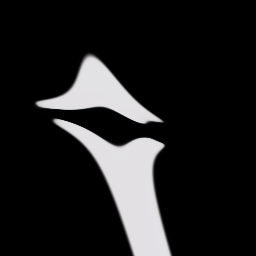

In [ ]:
show(vis[0])

That looks like style transfer to me!

In [ ]:
def eval_model(model=None, param_f=None, iters=200, show_every=50, show_num=5, target=None, cppn_params = {},
              optimizer_params = {"learning_rate": 0.005}):
    '''
    This function "trains" the CPNN (optimizes its weights to activate a particular neuron in the Inception model)
    and then returns a list of numpy arrays of [(weight, bias)] tuples.
    These can be used to output GLSL code in the subsequent step.
    '''        
    with tf.Graph().as_default() as graph, tf.Session() as sess:
        cppn_f = style_transfer_param(content_image, style_image)  # image_cppn(224, **cppn_params)
        optimizer = tf.train.AdamOptimizer(**optimizer_params)

        T = render.make_vis_T(model, target, param_f=cppn_f, optimizer=optimizer)
        
        loss, vis_op, t_image = T("loss"), T("vis_op"), T("input")
        tf.initialize_all_variables().run()
        to_show = []

        try:
            for i in range(iters):
                T("vis_op").run()
                print(f"{i}: {loss.eval():.3}", end=",", flush=True)
                to_show.append(t_image.eval()) # Should probably only do this when I know I'll show it.
                to_show = to_show[-show_num:]
                if (i+1)%show_every == 0:
                    show(np.concatenate(to_show, 0))
        except KeyboardInterrupt:
            print("INTERRUPTED")
        
        evaled = [var.eval() for var in cppn_f.graph.get_collection('trainable_variables')]
        print("EVALED", type(evaled[0]))
        grouped = []
        print(len(evaled))
        print([var.name for var in cppn_f.graph.get_collection('trainable_variables')])
        # Rearrange it into a nice dictionary
        for pos in range(0, len(evaled), 2):
            # This isn't completely elegant. I try to figure out what the activation
            # of this layer was, but I have to repeat some of th defaults inside the call
            # to image_cppn to do so.
            activation_fn = cppn_params.get('activation_fn', composite_activation)
            if isinstance(activation_fn, list):
                if pos//2 < len(activation_fn):
                    activation_fn = activation_fn[pos//2]
                else:
                    # This is a bit of a hack, the last layer is hardcoded to sigmoid activation
                    activation_fn = tf.nn.sigmoid
            grouped.append({'weights': evaled[pos], 
                           'bias': evaled[pos+1],
                            'activation': activation_fn
                           })
        return grouped

# OPTIMIZE

In [ ]:
evld = eval_model(model=model, iters=2048, target=objective)

In [ ]:
import numpy as np

def cppn_to_glsl(layers, fn_name="cppn_fn", mode="shadertoy", verbose=False,
                fix_aspect=True):
    '''
    Given a list of dicts defining layers of a trained CPPN (as returned by the above `eval_model` function) 
    generate GLSL code.
    
    The `mode` parameter can be one of the following:
    "shadertoy":
        Exports code compatible with the ShaderToy editor at http://shadertoy.com
    "bookofshaders":
        Exports code compatible with the Book Of Shaders editor here http://editor.thebookofshaders.com/
    "td":
        Exports code compatible with TouchDesigner: can be dropped into a "GLSL TOP"
        (see https://docs.derivative.ca/GLSL_TOP). TouchDesigner can be found at http://derivative.ca
    '''
    
    # the xy2rgb cppn's internal size is the output of its first layer (pre-activation)
    # so will just inspect that to figure it out
    n_hidden = layers[0]['weights'].shape[-1]
    if n_hidden%4 != 0:
        raise ValueError("Currently only support multiples of 4 for hidden layer size")
    modes = {"shadertoy", "bookofshaders", "td"}
    if mode not in modes:
        raise ValueError(f"Mode {mode} not one of the supported modes: {modes}")
        
    if mode == "bookofshaders":
        snippet =f"""
#ifdef GL_ES
precision lowp float;
#endif

uniform vec2 u_resolution;
uniform vec2 u_mouse;
uniform float u_time;
"""
    elif mode == "shadertoy":
        snippet = ""
    elif mode == "td":
        snippet = f"""
uniform float uIn0;
uniform float uIn1;
uniform float uIn2;
uniform float uIn3;

out vec4 fragColor;
        """
    
    snippet += f"""
#define N_HIDDEN {n_hidden}

vec4 bufA[N_HIDDEN/4];
vec4 bufB[N_HIDDEN/2];


vec4 {fn_name}(vec2 coordinate, float in0, float in1, float in2, float in3) {{
    vec4 tmp;
    bufB[0] = vec4(coordinate.x, coordinate.y, 0., 0.);
"""
    def vec(a):
        '''Take a Python array of length four (or less) and output code for
        a GLSL vec4, possibly zero-padded at the end'''
        if len(a) == 4:
            return f"vec4({','.join(str(x) for x in a)})"
        else:
            assert len(a) < 4 , "Length must less than 4"
            return vec(np.concatenate([a, [0.]*(4-len(a))]))
    
    def mat(a):
        '''Tak a numpy matrix of 4 rows and 4 or fewer columns, and output GLSL code
        for a mat4, possibly with zeros padded in the final columns'''
        if a.shape[0] < 4:
            m2 = np.vstack([a, [[0.,0.,0.,0.]] * (4 - a.shape[0])])
            return mat(m2)
        assert a.shape[0] == 4, f"Expected a of shape (4,n<=4). Got: {a.shape}."
        return f"mat4({','.join(vec(row) for row in a)})"
    
    for layer_i, layer_dict in enumerate(layers):
        weight = layer_dict['weights']
        bias = layer_dict['bias']
        activation = layer_dict['activation']
        
        _, _, from_size, to_size = weight.shape
        if verbose:
            print(f"Processing layer {layer_i}. from_size={from_size}, to_size={to_size}")
        
        # First, compute the transformation from the last layer into bufA
        for to_index in range(max(1,to_size//4)):
            #Again, the max(1) is important here, because to_size is 3 for the last layer!
            if verbose: print(f"  generating output {to_index} into bufA")
            snippet += f"bufA[{to_index}] = {vec(bias[to_index*4:to_index*4+4])}"
            for from_index in range(max(1,from_size//4)):
                # the "max" in the above loop gives us a special case for the first layer,
                # where there are only two inputs.
                snippet += f" + {mat(weight[0, 0, from_index*4:from_index*4+4, to_index*4:to_index*4+4])} * bufB[{from_index}]"
            if layer_i == 3:
                snippet += f" + in{to_index%4}"
            snippet += f";\n"
            
        if to_size != 3:
            if verbose: print("  Doing the activation into bufB ")
            for to_index in range(to_size//4):
                if activation == composite_activation:
                    snippet += f"tmp = sin(bufA[{to_index}]);\n"
                    snippet += f"bufB[{to_index}] = tmp/0.67;\n"
                    snippet += f"bufB[{to_index + to_size//4}] = (tmp*tmp) / 0.6;\n"
                elif activation == composite_activation_unbiased:
                    snippet += f"tmp = sin(bufA[{to_index}]);\n"
                    snippet += f"bufB[{to_index}] = tmp/0.67;\n"
                    snippet += f"bufB[{to_index + to_size//4}] = (tmp*tmp - 0.45) / 0.396;\n"
                    # return tf.concat([x/0.67, (x*x-0.45)/0.396], -1)
                elif activation == periodic_activation:
                    snippet += f"bufB[{to_index}] = sin(bufA[{to_index}]);\n"
                    snippet += f"bufB[{to_index + to_size//4}] = cos(bufA[{to_index}]);\n"
                elif activation == modulo_activation:
                    snippet += f"bufB[{to_index}] = mod(bufA[{to_index}], 2.0);\n"
                    snippet += f"bufB[{to_index + to_size//4}] = mod(bufA[{to_index}]+1.0, 2.0);\n"
                elif activation == modsin_activation:
                    snippet += f"bufB[{to_index}] = mod(bufA[{to_index}], 2.0*3.14159) / (2.0*3.14159) - 0.5;\n"
                    snippet += f"bufB[{to_index + to_size//4}] = sin(bufA[{to_index}]) / 0.5;\n"
    #                return tf.concat([tf.mod(x, 2.0*3.14159)/(2.0*3.14159)-0.5, tf.sin(x)/0.5], -1)

                elif activation == relu_normalized:
                    snippet += f"bufB[{to_index}] = (max(bufA[{to_index}], 0.) - 0.4 / 0.58);\n"
                    snippet += f"bufB[{to_index + to_size//4}] = (max(-bufA[{to_index}], 0.) - 0.4 / 0.58);\n"

                    #return (x-0.40)/0.58
                    # return tf.concat([(x-0.40)/0.58, (xx-0.40)/0.58], -1)
                else:
                    raise ValueError(f"Unknown activation: {activation.__name__}")
        else:
            if verbose:
                print("  Sigmoiding the last layer")
            # We just do a sigmoid at the last layer.
            sigmoider = lambda s: f"1. / (1. + exp(-{s}))"
            snippet += f"return vec4(({sigmoider('bufA[0]')}).xyz, 1.0);\n"
    snippet += "}\n"
    if mode=="bookofshaders":
        snippet += f"""
void main() {{
    vec2 st = gl_FragCoord.xy/u_resolution.xy;
"""
        if fix_aspect:
            snippet += f"""
    st.x *= u_resolution.x/u_resolution.y;
    st.x -= ((u_resolution.x / u_resolution.y) - 1.) /2.;
"""
        snippet += f"""
    st = vec2(1., -1.) * 2. * (st - vec2(0.5, 0.5));

    gl_FragColor = {fn_name}(st, sin(u_time), sin(2.*u_time), sin(3.*u_time), sin(4.*u_time));
}}
"""
    elif mode == "shadertoy":
        snippet += f"""
void mainImage( out vec4 fragColor, in vec2 fragCoord ) {{
    // Normalized pixel coordinates (from 0 to 1)
    vec2 uv = fragCoord/iResolution.xy;
    vec2 mouseNorm = (iMouse.xy / iResolution.xy) - vec2(0.5, 0.5);

"""
        if fix_aspect:
            snippet += f"""
    uv.x *= iResolution.x / iResolution.y;
    uv.x -= ((iResolution.x / iResolution.y) - 1.) /2.;
"""
        snippet += f"""

    // Shifted to the form expected by the CPPN
    uv = vec2(1., -1.) * 2. * (uv - vec2(0.5, 0.5));
    // Output to screen
    fragColor = {fn_name}(uv, sin(iTime), sin(2.*iTime), sin(3.*iTime), sin(4.*iTime));
}}
        """
    elif mode == "td":
        snippet += f"""
void main() {{
    // Normalized pixel coordinates (from 0 to 1)
    vec2 uv = vUV.xy;
"""
        if fix_aspect:
            snippet += f"""
    // TODO: don't kow how to find the resolution of the GLSL Top output to fix aspect...
"""
        snippet += f"""

    // Shifted to the form expected by the CPPN
    uv.xy = vec2(1., -1.) * 2. * (uv.xy - vec2(0.5, 0.5));
    // Output to screen
    fragColor = TDOutputSwizzle({fn_name}(uv.xy, uIn0, uIn1, uIn2, uIn3));
}}
        """
    return snippet

# GLSL export

In [ ]:
cppn_to_glsl(evld)

'\n#define N_HIDDEN 24\n\nvec4 bufA[N_HIDDEN/4];\nvec4 bufB[N_HIDDEN/2];\n\n\nvec4 cppn_fn(vec2 coordinate, float in0, float in1, float in2, float in3) {\n    vec4 tmp;\n    bufB[0] = vec4(coordinate.x, coordinate.y, 0., 0.);\nbufA[0] = vec4(-0.0944129,-0.1933993,-0.28949672,0.262625) + mat4(vec4(0.41581112146377563,-0.4226127862930298,0.6148977279663086,-0.5159242153167725),vec4(0.6522397994995117,-1.4032132625579834,-0.5392898917198181,0.20646803081035614),vec4(0.0,0.0,0.0,0.0),vec4(0.0,0.0,0.0,0.0)) * bufB[0];\nbufA[1] = vec4(-0.038007226,0.3820075,0.2780375,0.33116898) + mat4(vec4(-0.164750874042511,0.6186392903327942,0.24181154370307922,-0.5191462635993958),vec4(0.21804934740066528,-0.4237729609012604,-0.7089636325836182,0.9342571496963501),vec4(0.0,0.0,0.0,0.0),vec4(0.0,0.0,0.0,0.0)) * bufB[0];\nbufA[2] = vec4(-0.14791629,-0.30293626,0.1147422,0.093470566) + mat4(vec4(0.44662803411483765,0.539374589920044,1.2166270017623901,-0.060298386961221695),vec4(-0.09032276272773743,0.41450